## Modeling: Linear Regression for task difficulty --> neural activity

### Start with: neurons in visual cortex, session 11, 

Goal: 
    1. Build a simple linear regression model (task difficulty as an input, neural activity as an output) 
    2. Compute mean squared error (MSE)
    

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

## Import Libraries

In [2]:
import numpy as np
import os, requests
from matplotlib import pyplot as plt

# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
hide_toggle()

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Load Data

In [3]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [4]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11] # From session 11
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


### Group brain regions

In [5]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

## Plot: mean neural activity (mean of 340 trials) 

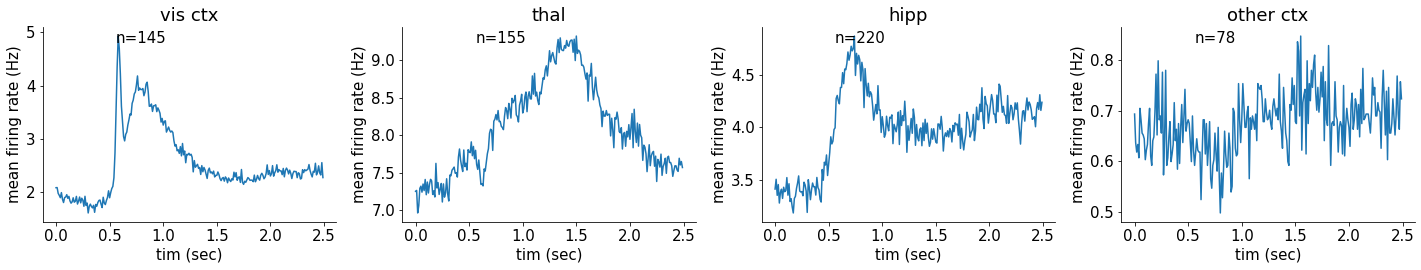

In [7]:
# plots by brain region and responses
response = dat['response'] # right - nogo - left (-1, 0, 1)
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
  
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j].mean(axis=(0,1)))
#     plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
#     plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

#     if j==0:
#         plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

## Plot: mean firing rate vs task difficulty

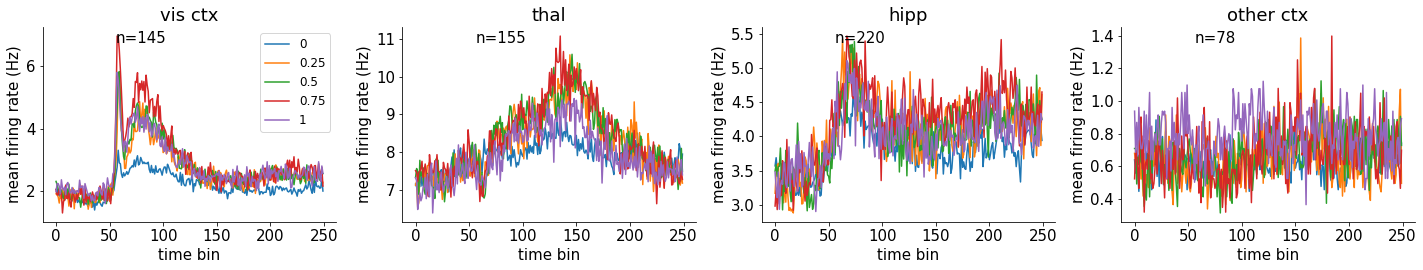

In [22]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'time bin', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

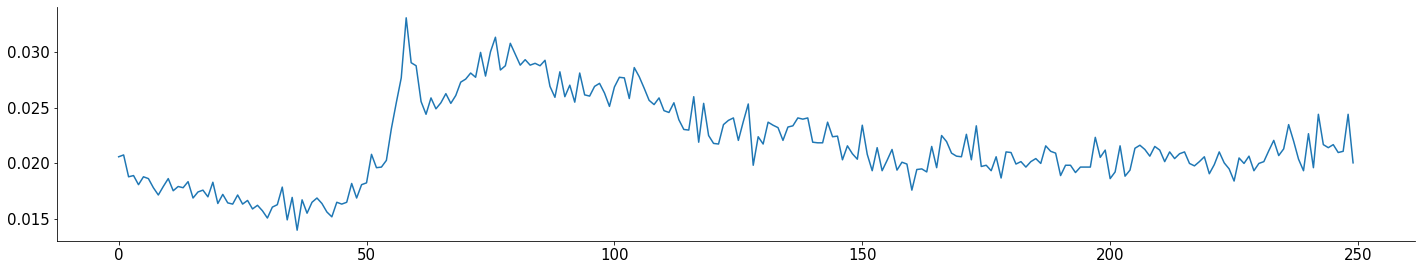

In [56]:
# np.mean(dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==0.5][:,:,:], axis=0).shape
np.mean(dat['spks'][barea==0][:,np.abs(l_cont-r_cont)==0], axis=1).mean(axis=0).shape
# test = np.mean(dat['spks'][barea==0][:,np.abs(l_cont-r_cont)==0], axis=1)
plt.plot(dat['spks'][barea==0][:,np.abs(l_cont-r_cont)==0].mean(axis=(0,1)))
plt.show()

In [101]:
# mean firing rate 
fm0 = np.mean(dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==0][:,:26,:], axis=(0,1)) 
fm1 = np.mean(dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==0][:,:26,:], axis=(0,1)) 
fm2 = np.mean(dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==0][:,:26,:], axis=(0,1)) 
fm3 = np.mean(dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==0][:,:26,:], axis=(0,1)) 
fm4 = np.mean(dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==0][:,:26,:], axis=(0,1)) 

(250,)

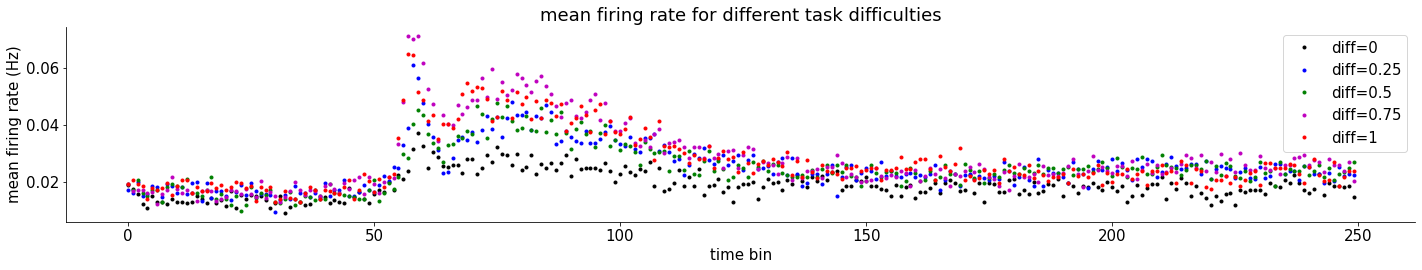

In [81]:
plt.plot(fm0,'k.', label='diff=0')
plt.plot(fm1, 'b.', label='diff=0.25')
plt.plot(fm2, 'g.', label='diff=0.5')
plt.plot(fm3, 'm.', label='diff=0.75')
plt.plot(fm4, 'r.', label='diff=1')

plt.title(r'mean firing rate for different task difficulties')
plt.xlabel('time bin')
plt.ylabel('mean firing rate (Hz)')
plt.legend()
plt.show()
hide_toggle()

## Setup for linear/polynomial regression

In [328]:
def ordinary_least_squares(X, y):
    """Ordinary least squares estimator for linear regression.

    Args:
    X (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

    Returns:
    ndarray: estimated parameter values of shape (n_regressors)
    """

    # Compute theta_hat using OLS
    theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

    return theta_hat

def make_design_matrix(x, order):
    """Create the design matrix of inputs for use in polynomial regression

    Args:
    x (ndarray): input vector of shape (n_samples) 
    order (scalar): polynomial regression order

    Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
    """
    # Broadcast to shape (n x 1) so dimensions work
    if x.ndim == 1:
        x = x[:, None]

    #if x has more than one feature, we don't want multiple columns of ones so we assign
    # x^0 here
    design_matrix = np.ones((x.shape[0], 1)) 

    # Loop through rest of degrees and stack columns (hint: np.hstack)
    for degree in range(1, order + 1):
        design_matrix = np.hstack((design_matrix, x**degree))

    return design_matrix

def solve_poly_reg(x, y, max_order):
    """Fit a polynomial regression model for each order 0 through max_order.

    Args:
    x (ndarray): input vector of shape (n_samples) 
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

    Returns:
    dict: fitted weights for each polynomial model (dict key is order)
    """
    # Create a dictionary with polynomial order as keys, and np array of theta 
    # (weights) as the values
    theta_hats = {}

    # Loop over polynomial orders from 0 through max_order
    for order in range(max_order + 1):
        X_design = make_design_matrix(x, order)
        this_theta = ordinary_least_squares(X_design, y)
        theta_hats[order] = this_theta

    return theta_hats
hide_toggle()

### Linear regression (test)

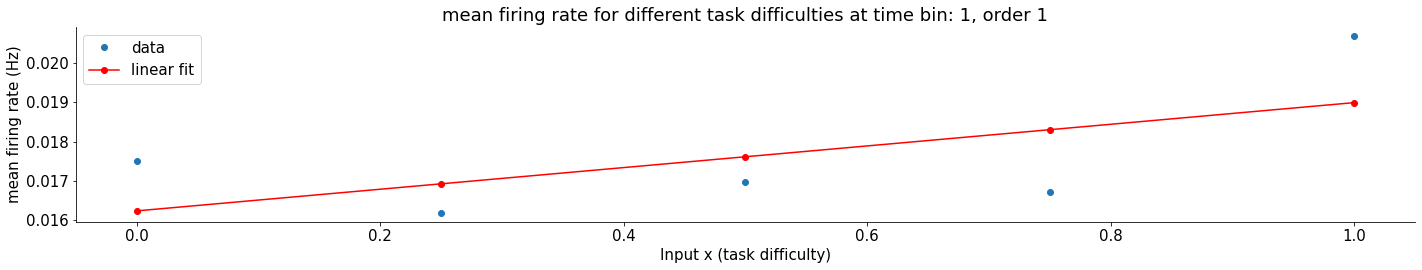

In [338]:
tbin = 1
x_diff = np.array([fm0[tbin], fm1[tbin], fm2[tbin], fm3[tbin], fm4[tbin]])

plt.plot(diff, x_diff,'o', label='data') #, label='diff=0')

max_order = 1
x_design = make_design_matrix(diff, max_order)
theta_hats = solve_poly_reg(diff, x_diff, max_order)
# print(theta_hats[max_order])
plt.plot(diff, x_design @ theta_hats[max_order], 'ro-', label='linear fit')

plt.title(r'mean firing rate for different task difficulties at time bin: %1.0f' %tbin +', order %1.0f'%max_order)
plt.xlabel('Input x (task difficulty)')
plt.ylabel('mean firing rate (Hz)')
plt.legend()
plt.show()

hide_toggle()

### Polynomial regression (test): 

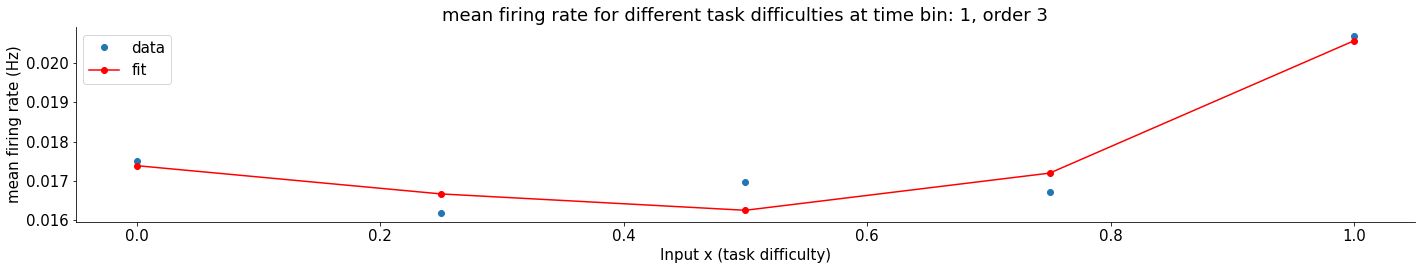

In [350]:
tbin = 1
x_diff = np.array([fm0[tbin], fm1[tbin], fm2[tbin], fm3[tbin], fm4[tbin]])

plt.plot(diff, x_diff,'o', label='data') #, label='diff=0')

max_order = 3
x_design = make_design_matrix(diff, max_order)
theta_hats = solve_poly_reg(diff, x_diff, max_order)
# print(theta_hats)
plt.plot(diff, x_design @ theta_hats[max_order], 'ro-', label='fit')

plt.title(r'mean firing rate for different task difficulties at time bin: %1.0f' %tbin +', order %1.0f'%max_order)
plt.xlabel('Input x (task difficulty)')
plt.ylabel('mean firing rate (Hz)')
plt.legend()
plt.show()

hide_toggle()

## Loop over 250 time bins

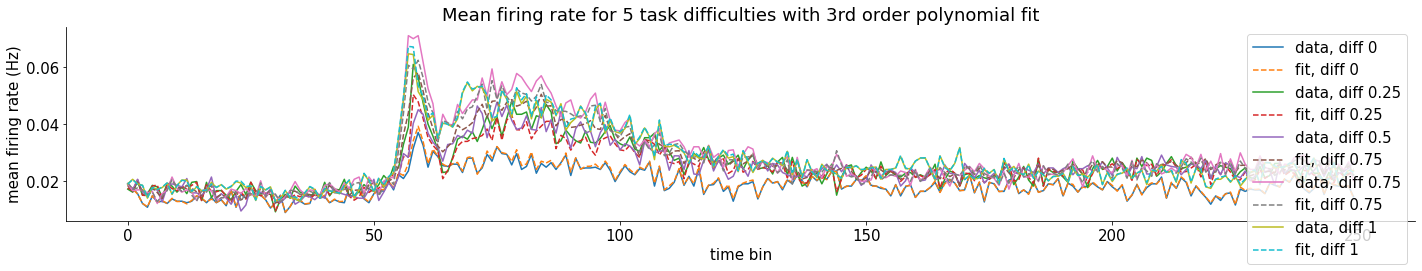

In [403]:
tbin = 250
max_order = 3
# theta_hat = np.zeros((tbin, 1, max_order+1)) # setup an array for storing theta_hat (parameter) values
fit_f = np.zeros((tbin, len(diff)))
# print(fit_f.shape)

for tbin in range(tbin):
    x_diff = np.array([fm0[tbin], fm1[tbin], fm2[tbin], fm3[tbin], fm4[tbin]]) # original data
    x_design = make_design_matrix(diff, max_order)
    theta_hats = solve_poly_reg(diff, x_diff, max_order)
#     theta_hat[tbin] = theta_hats[max_order]
    fit_f[tbin, :] = x_design @ theta_hats[max_order]

# print(theta_hats)

plt.plot(fm0, label='data, diff 0')
plt.plot(fit_f[:,0], '--', label='fit, diff 0')

plt.plot(fm1, label='data, diff 0.25')
plt.plot(fit_f[:,1], '--', label='fit, diff 0.25')

plt.plot(fm2, label='data, diff 0.5')
plt.plot(fit_f[:,2], '--', label='fit, diff 0.75')

plt.plot(fm3, label='data, diff 0.75')
plt.plot(fit_f[:,3], '--', label='fit, diff 0.75')

plt.plot(fm4, label='data, diff 1')
plt.plot(fit_f[:,4], '--', label='fit, diff 1')

# plt.plot(diff, x_diff,'o', label='data') #, label='diff=0')
# plt.plot(diff, x_design @ theta_hats[max_order], 'ro-', label='fit')

plt.title(r'Mean firing rate for 5 task difficulties with %1.0frd order polynomial fit'%max_order)
plt.xlabel('time bin')
plt.ylabel('mean firing rate (Hz)')
plt.legend()
plt.show()

hide_toggle()

### Simplest linear regression (model fitting): 

### Maximum likelihood estimation (MLE) test: 

## Application of W1D1_Tutorial 1

https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3_ModelFitting/student/W1D3_Tutorial1.ipynb#scrollTo=35Z-7MbAi9RP

plot_observed_vs_predicted(x, y, y_hat, theta_hat)

In [83]:
# Helper functions
def plot_observed_vs_predicted(x, y, y_hat, theta_hat):
    """ Plot observed vs predicted data

    Args:
      x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values

    """
    fig, ax = plt.subplots()
    ax.scatter(x, y, label='Observed')  # our data scatter plot
    ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model
    # plot residuals
    ymin = np.minimum(y, y_hat)
    ymax = np.maximum(y, y_hat)
    ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Residuals')
    ax.set(
      title=fr"$\hat{{\theta}}$ = {theta_hat:0.2f}, MSE = {mse(x, y, theta_hat):.2f}",
      xlabel='x',
      ylabel='y'
    )
    ax.legend()
hide_toggle()

mse(x, y, theta_hat)

In [84]:
def mse(x, y, theta_hat):
    """Compute the mean squared error

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta_hat (float): An estimate of the slope parameter

    Returns:
    float: The mean squared error of the data with the estimated parameter.
    """

    # Compute the estimated y 
    y_hat = theta_hat * x

    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return mse
hide_toggle()